## Install libraries

In [46]:
# Keras 2
#import os
#os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [1]:
!pip install -q datasets

In [2]:
!pip install openpyxl # for read excel

## Using TPU Cores

In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  #TPUClusterResolver, TPU'ların bulunduğu kümeyi (cluster) bulmak için kullanılır.
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
#Bu kod satırı, TensorFlow'u daha önce oluşturulan tpu nesnesi ile belirtilen TPU kümesine bağlar.
tf.tpu.experimental.initialize_tpu_system(tpu)
#Bu adım, TPU sistemini başlatır ve kullanıma hazır hale getirir.
tpu_strategy = tf.distribute.TPUStrategy(tpu)
#Modeli birden fazla TPU çekirdeğine dağıtarak eğitimi hızlandırır.

Tensorflow version 2.15.0
Running on a TPU w/8 cores


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Readind data

In [5]:
import numpy as np
import pandas as pd


In [6]:
df = pd.read_excel('/content/drive/MyDrive/GENAI-LLM/transformers-attention-transfer learning/trt_11_category.xlsx')
df

,Unnamed: 0.1,Unnamed: 0,title,context,category
0,0,0,BTK'nın sosyal ağ sağlayıcılara tanıdığı süre ...,Sosyal medya devlerinin temsilci bildirmesi iç...,bilim_teknoloji
1,1,1,Samsung Yönetim Kurulu Başkanı Lee hayatını ka...,Lee'nin oğlu ve Samsung'un fiili yöneticisi Le...,bilim_teknoloji
2,2,2,Yerli ve milli 5G şebekesi hedefi: Radyolink b...,Uçtan Uca Yerli ve Milli 5G Haberleşme Şebekes...,bilim_teknoloji
3,3,3,Elektrik direğindeki kaçağı haber veren akıllı...,"Enerjisa'dan yapılan açıklamaya göre, söz konu...",bilim_teknoloji
4,4,4,Sosyal medya sitelerinin temsilci bildirmesi i...,"Kamuoyunda ""Sosyal Medya Yasası"" olarak biline...",bilim_teknoloji
...,...,...,...,...,...
35195,3195,3195,Kahramanlığıyla iz bırakan Eren Bülbül'ün şeha...,"Eren Bülbül, Maçkalı Ayşe ve Hasan Bülbül çift...",yasam
35196,3196,3196,Kurban keserken nelere dikkat edilmeli? Kurban...,"Kurban Bayramı, Müslümanlar tarafından Hicri T...",yasam
35197,3197,3197,Sanatsever kardeşlerden Fatsa'da nostaljik fil...,Tiyatro ve sinemaya gönül veren Ali Can ve İlk...,yasam
35198,3198,3198,Yaralı kaplumbağalar rehabilitasyon merkezinde...,"Oltalar, balıkçı ağları, plastik atıklar... De...",yasam


In [7]:
df["context"] = df.title + " " + df.context


In [8]:
df = df[["context", "category"]]
df

,context,category
0,BTK'nın sosyal ağ sağlayıcılara tanıdığı süre ...,bilim_teknoloji
1,Samsung Yönetim Kurulu Başkanı Lee hayatını ka...,bilim_teknoloji
2,Yerli ve milli 5G şebekesi hedefi: Radyolink b...,bilim_teknoloji
3,Elektrik direğindeki kaçağı haber veren akıllı...,bilim_teknoloji
4,Sosyal medya sitelerinin temsilci bildirmesi i...,bilim_teknoloji
...,...,...
35195,Kahramanlığıyla iz bırakan Eren Bülbül'ün şeha...,yasam
35196,Kurban keserken nelere dikkat edilmeli? Kurban...,yasam
35197,Sanatsever kardeşlerden Fatsa'da nostaljik fil...,yasam
35198,Yaralı kaplumbağalar rehabilitasyon merkezinde...,yasam


In [9]:
df["category"].value_counts()

category
bilim_teknoloji    3200
dunya              3200
egitim             3200
ekonomi            3200
guncel             3200
gundem             3200
kultur_sanat       3200
saglik             3200
spor               3200
turkiye            3200
yasam              3200
Name: count, dtype: int64

In [10]:
unique_labels = df["category"].unique()
unique_labels

array(['bilim_teknoloji', 'dunya', 'egitim', 'ekonomi', 'guncel',
       'gundem', 'kultur_sanat', 'saglik', 'spor', 'turkiye', 'yasam'],
      dtype=object)

In [11]:
label_dict = {j:i for i, j in enumerate(unique_labels)}
label_dict

{'bilim_teknoloji': 0,
 'dunya': 1,
 'egitim': 2,
 'ekonomi': 3,
 'guncel': 4,
 'gundem': 5,
 'kultur_sanat': 6,
 'saglik': 7,
 'spor': 8,
 'turkiye': 9,
 'yasam': 10}

In [12]:
df.category = df.category.map(label_dict)
df

<ipython-input-12-484f92314f63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.category = df.category.map(label_dict)


,context,category
0,BTK'nın sosyal ağ sağlayıcılara tanıdığı süre ...,0
1,Samsung Yönetim Kurulu Başkanı Lee hayatını ka...,0
2,Yerli ve milli 5G şebekesi hedefi: Radyolink b...,0
3,Elektrik direğindeki kaçağı haber veren akıllı...,0
4,Sosyal medya sitelerinin temsilci bildirmesi i...,0
...,...,...
35195,Kahramanlığıyla iz bırakan Eren Bülbül'ün şeha...,10
35196,Kurban keserken nelere dikkat edilmeli? Kurban...,10
35197,Sanatsever kardeşlerden Fatsa'da nostaljik fil...,10
35198,Yaralı kaplumbağalar rehabilitasyon merkezinde...,10


In [13]:
X = df["context"].values
y = df["category"].values
# I used arrays because deep learning models are faster with arrays when compared to dataframes

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# stratify is used to make sure that both train and test sets have the same proportion of each class

## Pre-trained model Classification

In [15]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")

number_tokens_sentences = []
for sent in X_train:
   # Tokenize the text and add `[CLS]` and `[SEP]` tokens.

   input_ids = tokenizer.encode(str(sent),
                                add_special_tokens=True)
   number_tokens_sentences.append(len(input_ids))

print("Max sentence length: ", max(number_tokens_sentences))

# tokenizer.encode() fonksiyonunu sadece en uzun yorumun kaç tokenden oluştuğu bulmak ve tüm yorumları/textleri kaç
#tokene sabitliyeceğimize karar vermek için kullanacağız.

# use the tokenizer.encode() function only to find out how many tokens the longest comment has and how many tokens all comments/text have.
# We will use it to decide which token to pin it to.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1410 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  7769


In [16]:
sent = "How are you?"
tokenizer.encode(str(sent), add_special_tokens=True)

[2, 25223, 17379, 9751, 35, 3]

In [17]:
tokenizer.decode([2, 25223, 17379, 9751, 35, 3])

'[CLS] how are you? [SEP]'

In [18]:
list = [5, 10, 8, 9, 12, 15]
print(np.array(list) <= 11)
print(sum(np.array(list) <= 11))
print(sum(np.array(list) <= 11)/len(list))

# Örnek: Corpusumuzda 6 adet yorum olduğunu varsayalım. ilk yorum 5, ikinci yorum 10, üçüncü yorum 8, dördüncü yorum 9, beşinci
# yorum 12 ve altıncı yorum 15 tokenden oluşuyor.

# Tüm yorumları 11 tokene sabitlersem kaç yorumda bilgi/token kaybı olmayacağına bakalım.

# ilk 4 yorumda herhangi bir bilgi/token kaybı olmayacak, ancak 5. yorumda 1 token, 6. yorumda 4 token kaybı olacak.
# np.array(list) <= 11 kodu ile tüm yorumları 11 tokene sabitlediğimizde bilgi/token kaybı olmayan yorumların True olarak,
# bilgi/token kaybı olanların False olarak döndürülmesini sağlıyorum --> [ True  True  True  True False False]
# sum(np.array(list) <= 11) kodu ile öncelikle Truelar 1'e, Falselar 0'a dönüştürülür. Sonra da bu değerler toplanır. Çıkan
# sonuç kaç yorumda bilgi/token kaybı olmadığını bize gösterir.
# [True  True  True  True False False]-->[1 1 1 1 0 0]--> sum([1 1 1 1 0 0])-->4 --> cospusumdaki 6 yorumun 4'ünde bilgi/token
# kaybı yok.
# Elde ettiğimiz 4 sonucunu corpsumuzdaki tüm yorumların sayısına (len([5, 10, 8, 9, 12, 15])-->6) böldüğümüzde bize oran
# olarak kaç yorumda bilgi/token kaybı olmadığını döndürür (4/6 --> 0.67). Biz bu oranın %95 ve üzeri olmasını istiyoruz.

# Example: Suppose there are 6 comments in our corpus. first comment 5, second comment 10, third comment 8, fourth comment 9, fifth
# comment 12 and sixth comment 15 tokens.

# Let's see how many comments will not lose information/tokens if I fix all comments at 11 tokens.

# the first 4 comments will not lose any information/token, but comment 5 will lose 1 token and comment 6 will lose 4 tokens.
# When we fix all comments to 11 tokens with the code np.array(list) <= 11, we can see that the comments with no loss of information/token are True,
# I make sure that any loss of information/token is returned as False --> [ [ True True True True True False False False]
# sum(np.array(list) <= 11) first converts Truelar to 1 and Falselar to 0. Then these values are summed. The result
# the result tells us how many comments have no information/token loss.
# [True True True True True True False False]-->[1 1 1 1 1 1 0 0]--> sum([1 1 1 1 1 1 0 0])-->4 --> information/token in 4 out of 6 comments in my cospusum
# no loss.
# Dividing the result 4 by the number of all comments in our corpus (len([5, 10, 8, 9, 12, 15])-->6) gives us the ratio
# returns how many comments have no information/token loss (4/6 --> 0.67). We want this ratio to be 95% and above.


[ True  True  True  True False False]
4
0.6666666666666666


In [19]:
sum(np.array(number_tokens_sentences) <= 512)/len(number_tokens_sentences)

0.7025213068181818

## Converting Data to Dataset Format

In [20]:
train_text=[]
for i, j in zip(X_train, y_train):
  train_text.append({"text": str(i), "label":j})

test_text=[]
for i, j in zip(X_test, y_test):
  test_text.append({"text": str(i), "label":j})

In [21]:
train_text[0:2]

[{'text': "Artistik buz pateni yarışmalarına koronavirüs engeli Türkiye Buz Pateni Federasyonundan yapılan açıklamada, ISU Konsey Toplantısı'nın ardından alınan kararlar doğrultusunda, Junior Grand Prix yarışmalarının sürdürülemeyeceği ve serinin tüm etkinliklerinin iptal edildiği ifade edildi. İptal kararının, sağlık komisyonunun önerileri ile etkinlik katılımcılarının güvenliği ve sağlığının gözetilerek alındığı belirtildi. Yeni sezon planlamasının ve diğer etkinliklerin ise 3 Ağustos'ta çevrim içi düzenlenecek toplantıda tekrar değerlendirileceği aktarıldı.",
  'label': 8},
 {'text': 'ASELSAN "en çekici işveren" seçildi ASELSAN\'dan yapılan açıklamaya göre, Universum 2018 Türkiye’nin Öğrenci ve Çalışan Y Kuşağı İçin En Çekici İşverenler Araştırması sonuçları açıklandı. Universum tarafından 61 ülkede 1,8 milyon genç ile yapılan En Çekici İşveren Araştırması\'nın Türkiye ayağı, 6. yılında 46 üniversiteden 41 bin 117 öğrenci ve ortalama 3 yıldır iş hayatında olan 13 bin 116 genç profes

In [22]:
from datasets import Dataset

train_dataset = Dataset.from_list(train_text)
test_dataset = Dataset.from_list(test_text)
# huggingface needs this dataset format

In [23]:
train_dataset[:3]

{'text': ["Artistik buz pateni yarışmalarına koronavirüs engeli Türkiye Buz Pateni Federasyonundan yapılan açıklamada, ISU Konsey Toplantısı'nın ardından alınan kararlar doğrultusunda, Junior Grand Prix yarışmalarının sürdürülemeyeceği ve serinin tüm etkinliklerinin iptal edildiği ifade edildi. İptal kararının, sağlık komisyonunun önerileri ile etkinlik katılımcılarının güvenliği ve sağlığının gözetilerek alındığı belirtildi. Yeni sezon planlamasının ve diğer etkinliklerin ise 3 Ağustos'ta çevrim içi düzenlenecek toplantıda tekrar değerlendirileceği aktarıldı.",
  'ASELSAN "en çekici işveren" seçildi ASELSAN\'dan yapılan açıklamaya göre, Universum 2018 Türkiye’nin Öğrenci ve Çalışan Y Kuşağı İçin En Çekici İşverenler Araştırması sonuçları açıklandı. Universum tarafından 61 ülkede 1,8 milyon genç ile yapılan En Çekici İşveren Araştırması\'nın Türkiye ayağı, 6. yılında 46 üniversiteden 41 bin 117 öğrenci ve ortalama 3 yıldır iş hayatında olan 13 bin 116 genç profesyonelden edinilen bilgi

In [24]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 28160
})

## Tokenization

In [25]:
sentence="How are you?"

tokenized_data = tokenizer(text=sentence,
                           return_tensors = "np",
                           padding = "max_length",
                           truncation = True,
                           max_length = 7,
                           add_special_tokens = True)
tokenized_data

{'input_ids': array([[    2, 25223, 17379,  9751,    35,     3,     0]]), 'token_type_ids': array([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, 1, 1, 1, 0]])}

In [26]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")
def transformation(examples):
  seq=512
  tokenized_data = tokenizer(text=examples["text"],
                             return_tensors="np",
                             padding="max_length",
                             truncation=True,
                             max_length=seq,
                             add_special_tokens=True)
  return tokenized_data

train_tokenized_data = train_dataset.map(transformation, batched=True)
test_tokenized_data = test_dataset.map(transformation, batched=True)

Map:   0%|          | 0/28160 [00:00<?, ? examples/s]

Map:   0%|          | 0/7040 [00:00<?, ? examples/s]

In [27]:
train_tokenized_data

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 28160
})

In [28]:
test_tokenized_data

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7040
})

In [29]:
train_tokenized_data["input_ids"][0]

[2,
 2488,
 4866,
 5794,
 3339,
 2194,
 5093,
 10542,
 5112,
 2106,
 27927,
 8423,
 1977,
 2132,
 25237,
 23216,
 5794,
 3339,
 2194,
 7789,
 17784,
 2697,
 20562,
 2177,
 1986,
 16,
 2578,
 1013,
 13843,
 7134,
 11,
 2757,
 3146,
 4365,
 10487,
 18029,
 1012,
 3073,
 14343,
 16,
 18011,
 9078,
 1024,
 14400,
 14683,
 1076,
 5093,
 10542,
 5112,
 2196,
 3304,
 2553,
 17634,
 2663,
 2098,
 2287,
 1992,
 20051,
 21155,
 27814,
 1973,
 6021,
 4396,
 2287,
 3069,
 4396,
 18,
 6021,
 12377,
 16,
 9752,
 2090,
 30946,
 12496,
 2819,
 2068,
 2081,
 4539,
 17642,
 1976,
 6856,
 2521,
 16282,
 1992,
 9752,
 1991,
 22565,
 1014,
 21540,
 3025,
 18840,
 6475,
 2958,
 6797,
 18,
 2312,
 3791,
 22138,
 10779,
 1992,
 17319,
 27814,
 2365,
 23,
 7996,
 3566,
 2249,
 11,
 2108,
 3231,
 5865,
 4470,
 1023,
 27010,
 1975,
 15931,
 8238,
 3347,
 19912,
 2654,
 2616,
 2098,
 2287,
 31604,
 18,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [30]:
train_tokenized_data["input_ids"][:2]

[[2,
  2488,
  4866,
  5794,
  3339,
  2194,
  5093,
  10542,
  5112,
  2106,
  27927,
  8423,
  1977,
  2132,
  25237,
  23216,
  5794,
  3339,
  2194,
  7789,
  17784,
  2697,
  20562,
  2177,
  1986,
  16,
  2578,
  1013,
  13843,
  7134,
  11,
  2757,
  3146,
  4365,
  10487,
  18029,
  1012,
  3073,
  14343,
  16,
  18011,
  9078,
  1024,
  14400,
  14683,
  1076,
  5093,
  10542,
  5112,
  2196,
  3304,
  2553,
  17634,
  2663,
  2098,
  2287,
  1992,
  20051,
  21155,
  27814,
  1973,
  6021,
  4396,
  2287,
  3069,
  4396,
  18,
  6021,
  12377,
  16,
  9752,
  2090,
  30946,
  12496,
  2819,
  2068,
  2081,
  4539,
  17642,
  1976,
  6856,
  2521,
  16282,
  1992,
  9752,
  1991,
  22565,
  1014,
  21540,
  3025,
  18840,
  6475,
  2958,
  6797,
  18,
  2312,
  3791,
  22138,
  10779,
  1992,
  17319,
  27814,
  2365,
  23,
  7996,
  3566,
  2249,
  11,
  2108,
  3231,
  5865,
  4470,
  1023,
  27010,
  1975,
  15931,
  8238,
  3347,
  19912,
  2654,
  2616,
  2098,
  2287,
  

## Create Optimizer and Training with TPU Cores

In [31]:
len(train_tokenized_data["input_ids"])//32

880

In [32]:
from transformers import create_optimizer

batch_size = 32 #16
num_train_epochs = 2 #3, 4
num_train_steps = len(train_tokenized_data["input_ids"])//batch_size * num_train_epochs
optimizer, lr_schedule = create_optimizer(init_lr=2e-5, #3e-5, 5e-5
                                          num_train_steps=num_train_steps,
                                          weight_decay_rate=0.01, # ağırlik küçülme oranı
                                          num_warmup_steps=0.1) # ısınma adımları sayısı

In [33]:
optimizer

In [34]:
lr_schedule.get_config()

{'initial_learning_rate': 2e-05,
 'decay_schedule_fn': <tf_keras.src.optimizers.schedules.learning_rate_schedule.PolynomialDecay at 0x7d06ac15ac50>,
 'warmup_steps': 0.1,
 'power': 1.0,
 'name': None}

In [35]:
optimizer.get_config()

{'name': 'AdamWeightDecay',
 'learning_rate': {'module': 'transformers.optimization_tf',
  'class_name': 'WarmUp',
  'config': {'initial_learning_rate': 2e-05,
   'decay_schedule_fn': {'module': 'keras.optimizers.schedules',
    'class_name': 'PolynomialDecay',
    'config': {'initial_learning_rate': 2e-05,
     'decay_steps': 1759.9,
     'end_learning_rate': 0.0,
     'power': 1.0,
     'cycle': False,
     'name': None},
    'registered_name': None},
   'warmup_steps': 0.1,
   'power': 1.0,
   'name': None},
  'registered_name': 'WarmUp'},
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-08,
 'amsgrad': False,
 'weight_decay_rate': 0.01}

In [36]:
with tpu_strategy.scope():

    from transformers import TFAutoModelForSequenceClassification

    #from tensorflow.keras.optimizers import AdamW
    #from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy

    # Load and compile our model
    model = TFAutoModelForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-uncased",
                                                                 num_labels=11)
    # loss= SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.ReductionV2.NONE)


    model.compile(optimizer=optimizer, metrics=["accuracy"])  # No loss argument!

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
tf_dataset_train = model.prepare_tf_dataset(train_tokenized_data, batch_size=32, shuffle=False)
tf_dataset_test = model.prepare_tf_dataset(test_tokenized_data, batch_size=32, shuffle=False)
# TPU için tensorflowa çevirdik

In [38]:
tf_dataset_train

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [39]:
model.fit(tf_dataset_train,
          validation_data=(tf_dataset_test),
          epochs=num_train_epochs)

Epoch 1/2


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
880/880 [==============================] - 311s 208ms/step - loss: 0.7226 - accuracy: 0.7762 - val_loss: 0.5200 - val_accuracy: 0.8212
Epoch 2/2
880/880 [==============================] - 164s 187ms/step - loss: 0.4128 - accuracy: 0.8664 - val_loss: 0.4746 - val_accuracy: 0.8403


In [40]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  8459      
                                                                 
Total params: 110625803 (422.00 MB)
Trainable params: 110625803 (422.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Evaluation

In [41]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.722599,0.776243,0.520026,0.821165
1,0.412841,0.866371,0.474620,0.840341


<Axes: >

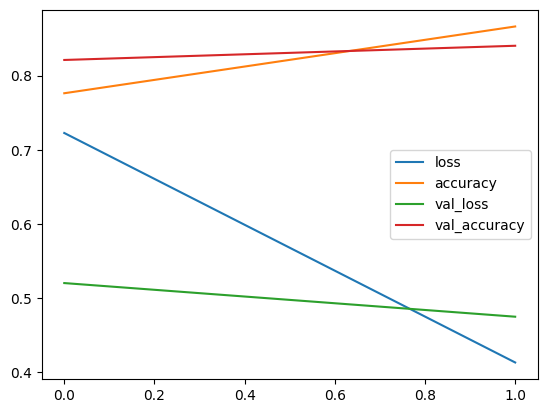

In [42]:
model_loss.plot()

"Logits" terimi, derin öğrenme modelleri ve sinir ağlarında sıkça kullanılan bir terimdir. Logits, modelin son katmanından çıkan, genellikle bir doğrusal dönüşüm ve bir aktivasyon fonksiyonundan önceki ham puanları ifade eder.

Bir sınıflandırma probleminde, logits çıktıları genellikle aşağıdaki gibi yorumlanır:

- **Çok sınıflı sınıflandırma**: Modelin farklı sınıflar için hesapladığı ham puanlar. Bu puanlar, genellikle softmax fonksiyonu uygulanarak olasılıklara dönüştürülür.
- **İkili sınıflandırma**: İki sınıf arasındaki karar sınırını belirlemek için kullanılan ham puanlar. Bu puanlar, sigmoid fonksiyonu ile olasılıklara dönüştürülür.

Logits değerlerini anlamak için şu adımları izleyebilirsiniz:
1. **Softmax Uygulama**: Logits değerlerini olasılıklara dönüştürmek için softmax fonksiyonunu kullanabilirsiniz. Bu, her sınıf için olasılıkların toplamının 1 olmasını sağlar.
2. **Tahmin**: En yüksek olasılığa sahip sınıf, modelin tahmini olarak seçilir.

The term "logits" is frequently used in deep learning models and neural networks. Logits refers to the raw scores coming out of the last layer of the model, usually before a linear transformation and an activation function.

In a classification problem, logits outputs are usually interpreted as follows:

- **Multi-class classification**: Raw scores computed by the model for different classes. These scores are converted into probabilities, usually by applying the softmax function.
- Binary classification**: Raw scores used to determine the decision boundary between two classes. These scores are converted into probabilities using the sigmoid function.

You can follow these steps to understand Logits values:
1. **Softmax Application**: You can use the softmax function to convert logits values into probabilities. This ensures that the sum of the probabilities for each class is 1.
2. **Forecast**: The class with the highest probability is selected as the model's prediction.


In [43]:
logits = model.predict(tf_dataset_test)
logits

220/220 [==============================] - 28s 53ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[ 1.6053234e+00, -8.7514895e-01, -7.7429938e-01, ...,
        -1.7043481e+00, -6.3561398e-01, -9.4547760e-01],
       [-1.9886305e+00, -1.9494303e+00, -1.0720901e+00, ...,
        -1.3490338e+00,  4.2765188e+00,  4.1223282e-01],
       [-1.7691598e+00, -1.7310499e+00, -1.4021813e+00, ...,
        -8.5593331e-01,  5.2967048e+00,  8.2503098e-01],
       ...,
       [ 2.9497976e+00, -1.3318757e+00, -1.1348536e+00, ...,
        -1.1722957e+00, -8.6197257e-02, -1.2627522e+00],
       [-1.9480865e-01,  4.0079720e-02, -9.2344409e-01, ...,
         6.9464931e+00, -8.6234134e-01, -4.4288418e-01],
       [ 5.3305793e+00, -4.1438867e-03,  1.2533759e+00, ...,
        -9.7186047e-01, -1.3940202e+00,  1.2362331e+00]], dtype=float32), hidden_states=None, attentions=None)

In [44]:
logits.logits

array([[ 1.6053234e+00, -8.7514895e-01, -7.7429938e-01, ...,
        -1.7043481e+00, -6.3561398e-01, -9.4547760e-01],
       [-1.9886305e+00, -1.9494303e+00, -1.0720901e+00, ...,
        -1.3490338e+00,  4.2765188e+00,  4.1223282e-01],
       [-1.7691598e+00, -1.7310499e+00, -1.4021813e+00, ...,
        -8.5593331e-01,  5.2967048e+00,  8.2503098e-01],
       ...,
       [ 2.9497976e+00, -1.3318757e+00, -1.1348536e+00, ...,
        -1.1722957e+00, -8.6197257e-02, -1.2627522e+00],
       [-1.9480865e-01,  4.0079720e-02, -9.2344409e-01, ...,
         6.9464931e+00, -8.6234134e-01, -4.4288418e-01],
       [ 5.3305793e+00, -4.1438867e-03,  1.2533759e+00, ...,
        -9.7186047e-01, -1.3940202e+00,  1.2362331e+00]], dtype=float32)

In [45]:
logits.logits[0]

array([ 1.6053234 , -0.87514895, -0.7742994 ,  4.7612596 , -0.5325009 ,
        1.52299   , -1.6633148 , -0.90580493, -1.7043481 , -0.635614  ,
       -0.9454776 ], dtype=float32)

In [46]:
import tensorflow as tf

probabilities = tf.nn.softmax(logits.logits, axis=-1).numpy()
probabilities

array([[3.8416754e-02, 3.2156245e-03, 3.5568352e-03, ..., 1.4032939e-03,
        4.0859585e-03, 2.9972431e-03],
       [1.1497124e-03, 1.1956759e-03, 2.8749979e-03, ..., 2.1795279e-03,
        6.0465676e-01, 1.2684427e-02],
       [7.9170731e-04, 8.2246138e-04, 1.1427243e-03, ..., 1.9732127e-03,
        9.2732215e-01, 1.0597595e-02],
       ...,
       [3.5185081e-01, 4.8624082e-03, 5.9213014e-03, ..., 5.7036942e-03,
        1.6898287e-02, 5.2104052e-03],
       [7.8677345e-04, 9.9508523e-04, 3.7967082e-04, ..., 9.9375099e-01,
        4.0359321e-04, 6.1392016e-04],
       [9.3425786e-01, 4.5042867e-03, 1.5840171e-02, ..., 1.7114019e-03,
        1.1220453e-03, 1.5570940e-02]], dtype=float32)

In [47]:
y_pred = np.argmax(probabilities, axis=1)
y_pred

array([3, 9, 9, ..., 0, 8, 0])

In [48]:
def classification(tokenized_data):
  import tensorflow as tf
  import numpy as np

  logits = model.predict(tokenized_data)
  probabilities = tf.nn.softmax(logits.logits, axis=-1).numpy()
  y_pred = np.argmax(probabilities, axis=1)
  return y_pred


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = classification(tf_dataset_test)
print(classification_report(y_test, y_pred, target_names=unique_labels))




220/220 [==============================] - 13s 53ms/step
                 precision    recall  f1-score   support

bilim_teknoloji       0.84      0.91      0.88       640
          dunya       0.92      0.88      0.90       640
         egitim       0.90      0.95      0.92       640
        ekonomi       0.84      0.87      0.85       640
         guncel       0.75      0.81      0.78       640
         gundem       0.82      0.75      0.79       640
   kultur_sanat       0.81      0.90      0.85       640
         saglik       0.84      0.88      0.86       640
           spor       0.98      0.97      0.98       640
        turkiye       0.77      0.63      0.70       640
          yasam       0.76      0.69      0.73       640

       accuracy                           0.84      7040
      macro avg       0.84      0.84      0.84      7040
   weighted avg       0.84      0.84      0.84      7040



In [50]:
y_train_pred = classification(tf_dataset_train)
print(classification_report(y_train, y_train_pred, target_names=unique_labels))

880/880 [==============================] - 48s 53ms/step
                 precision    recall  f1-score   support

bilim_teknoloji       0.89      0.96      0.92      2560
          dunya       0.96      0.91      0.93      2560
         egitim       0.91      0.97      0.94      2560
        ekonomi       0.88      0.91      0.90      2560
         guncel       0.84      0.86      0.85      2560
         gundem       0.87      0.81      0.84      2560
   kultur_sanat       0.86      0.94      0.90      2560
         saglik       0.89      0.94      0.91      2560
           spor       0.99      0.99      0.99      2560
        turkiye       0.86      0.74      0.80      2560
          yasam       0.85      0.77      0.81      2560

       accuracy                           0.89     28160
      macro avg       0.89      0.89      0.89     28160
   weighted avg       0.89      0.89      0.89     28160



## Saving and Loading the model

In [53]:
model.save_pretrained("/content/drive/MyDrive/GENAI-LLM/transformers-attention-transfer learning/saved_model")

In [54]:
with tpu_strategy.scope():
  loaded_model = TFAutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/GENAI-LLM/transformers-attention-transfer learning/saved_model")

Some layers from the model checkpoint at /content/drive/MyDrive/GENAI-LLM/transformers-attention-transfer learning/saved_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/GENAI-LLM/transformers-attention-transfer learning/saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequ

## Prediction

In [55]:
sample1="Meteorolojiden kuvvetli yağış uyarısı Meteoroloji Genel Müdürlüğünden yapılan uyarıya göre, yarın Kıyı Ege \
(İzmir, Aydın, Muğla, Manisa) ile Edirne'nin güneyi, Balıkesir'in batı kıyıları (Edremit, Ayvalık, Burhaniye, Havran, \
Gömeç ilçeleri) ve Çanakkale çevrelerinde kuvvetli ve yer yer çok kuvvetli, gök gürültülü sağanak öngörülüyor. Ani sel, \
su baskını, yıldırım, yağış anında kuvvetli rüzgar, yerel dolu yağışı ve hortum gibi olumsuzluklara karşı dikkatli ve \
tedbirli olunması gerekiyor."

In [56]:
sample2="""Teknopark İstanbul'un Rejenerasyon-20 projesine başvurular başladı Teknopark İstanbul açıklamasına göre, evde yaşam,\
 erişim-lojistik, uzaktan çalışma ve sosyal girişim konularında çalışmalar yapan ön kuluçka ve kuluçka aşamasına gelen \
 girişimcilerin başvurabileceği Rejenerasyon-20 projesi girişim ekosisteminin yeniden yapılanmasını kapsıyor. Projeyle; \
 prototip üretme, prototip geliştirme veya ürünleşme aşamasındaki girişimlere dijital hızlandırma, ticarileşme aşamasındaki \
 girişimlere ise danışmanlık programı verilecek. Danışmanlık programından; ürününü bitirmiş, "scale up" aşamasında olan ya da \
 salgından önce gelir üretebilen fakat şu an iş yapmakta zorlanan genç girişimler yararlanabilecek. Başvuruların 3-17 Temmuz'da \
 gerçekleştirilebileceği Rejenerasyon-20 Projesi'ne, rejenerasyon20.com adresinden başvurulabiliyor. Dijital Hızlandırma Programı'na\
  başlayacak olan 15 girişim grubu; proje ekibi, teknik destek yetkilisi ve insan kaynakları danışmanının ortak görüşü ile \
  değerlendirmeye alınacak. 150 saat mentorluk desteği verilecek Program boyunca girişim gruplarına toplamda; 50 saat finansal \
  danışmanlık desteği, 360 saat teknik analiz, yazılım danışmanlığı ve test desteği, 150 saat mentorluk desteği, 150 saat insan \
  kaynakları danışmanlığı, 30 saat hukuk danışmanlık desteği, 30 saat fikri ve sınai mülkiyet haklar danışmanlık desteği, \
  stratejik marka iletişimi ve dijital pazarlama danışmanlığı, iş geliştirme ve pazarlama desteği, prototipleme-üretim \
  danışmanlığı, kapsamlı stratejik analiz ve plan oluşturma desteği, 6 ay boyunca iş geliştirme uygulamaları desteği \
  gibi destekler sunulacak. Ara değerlendirme sonrasında elemeden geçecek 15 girişimci sayısı jüri elemesi sonucu 10'a \
  düşürülecek. İkinci aşamaya geçen 10 girişime ayrıca; sosyal medya tanıtım desteği, kurumsal kimlik ve dijital tasarım \
  desteği, 100 saat kullanıcı ara yüz tasarım desteği, prototipleme desteği, 2 yıl boyunca bulut veri depolama hizmeti \
  sunulacak. Program sonunda 10 girişim, "demoday" etkinliğinde kurumsal firma ve yatırımcılara sunum yapma fırsatına \
  erişecek. Danışmanlık başvurusundan ise 25 girişim yararlanabilecek. Bu girişimlere toplamda 300 saatlik psikolojik, \
  finansal ve pazarlama danışmanlığı verilecek. Öte yandan, projenin son ayağı olan Video Portal Modülü ile daha büyük \
  kitleye hitap edilecek ve girişimlerin en çok merak ettiği 100 soru konunun uzmanları tarafından kısa videolarla cevaplanacak. \
  "Uluslararası arenada rekabet eden ürünlerin hayata geçeceğine inanıyoruz" Açıklamada görüşlerine yer verilen Teknopark İstanbul \
  Genel Müdürü Bilal Topçu, destekten yararlanacak girişimcilerin; kalıcı, uygulanabilir ve çağdaş metotlara dayanan destek \
  mekanizmalarıyla projelerini başarıyla hayata geçireceklerini belirterek, şunları kaydetti: "Rejenerasyon-20 ile \
  girişimcilik ekosistemimizdeki başarılı genç beyinlerimizin uluslararası arenada rekabet eden ürünler ve uygulamalar hayata \
  geçireceğine inanıyoruz."""

In [57]:
samples=[]
for i in [sample1, sample2]:
  samples.append({"text": str(i)})

In [58]:
def prep_data(samples, model):
  from datasets import Dataset
  samples_dataset = Dataset.from_list(samples)
  samples_tokenized_data = samples_dataset.map(transformation, batched=True)
  tf_dataset_samples = model.prepare_tf_dataset(samples_tokenized_data , batch_size=32, shuffle=False)
  return tf_dataset_samples

In [59]:
tf_dataset_samples=prep_data(samples, loaded_model)

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [60]:
logits=loaded_model.predict(tf_dataset_samples)
logits

1/1 [==============================] - 18s 18s/step


TFSequenceClassifierOutput(loss=None, logits=array([[-1.9886305 , -1.9494303 , -1.0720901 , -1.6243185 ,  3.7346227 ,
         0.5790643 , -1.6899599 , -0.4470524 , -1.3490338 ,  4.276519  ,
         0.41223282],
       [ 4.286585  , -1.2803872 , -0.26353076,  2.3805995 ,  0.38078097,
         0.4056866 , -1.4456244 , -1.2487619 , -0.894213  , -0.47058263,
        -1.4262745 ]], dtype=float32), hidden_states=None, attentions=None)

In [61]:
probs= tf.nn.softmax(logits.logits, axis=-1).numpy()
probs

array([[0.00114971, 0.00119568, 0.002875  , 0.00165504, 0.3516952 ,
        0.01498735, 0.00154989, 0.00537141, 0.00217953, 0.6046568 ,
        0.01268443],
       [0.8139859 , 0.00311108, 0.00860056, 0.12102022, 0.01638128,
        0.01679439, 0.00263724, 0.00321104, 0.00457746, 0.00699206,
        0.00268877]], dtype=float32)

In [62]:
y_pred = np.argmax(probs, axis=1)
y_pred

array([9, 0])

In [63]:
label_dict

{'bilim_teknoloji': 0,
 'dunya': 1,
 'egitim': 2,
 'ekonomi': 3,
 'guncel': 4,
 'gundem': 5,
 'kultur_sanat': 6,
 'saglik': 7,
 'spor': 8,
 'turkiye': 9,
 'yasam': 10}

In [64]:
classification(tf_dataset_samples)

1/1 [==============================] - 16s 16s/step


array([9, 0])